# Amazon Review - Sentiment Analysis

Analyzing the Amazon reviews dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [8]:
import numpy as np
!pip install wordcloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Erjon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#%pip install xgboost

### Exploratory Data Analysis

In [10]:
#Load the data

data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [11]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [12]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [13]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [43]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(lambda x: len(x) if not pd.isna(x) else 0)

In [44]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [45]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [46]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [47]:
len(data)

3150

In [48]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64


Let's plot the above values in a bar graph

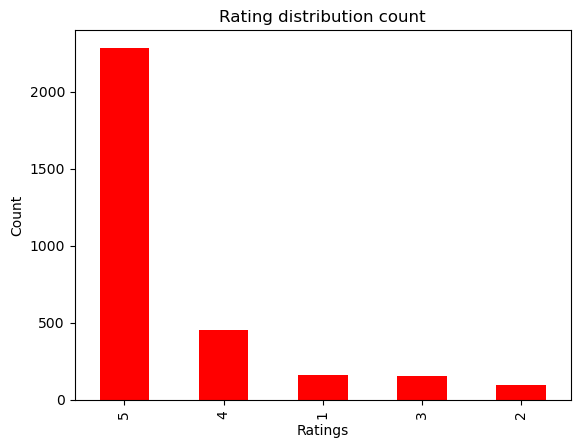

In [49]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [50]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: count, dtype: float64


Let's plot the above values in a pie chart

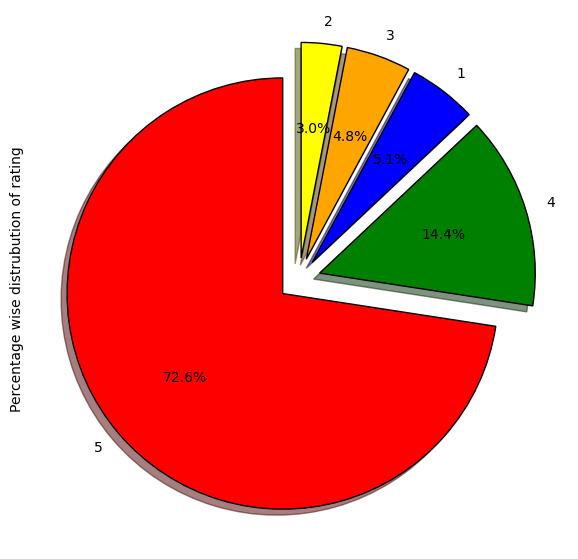

In [51]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [52]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     257
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [53]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [54]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

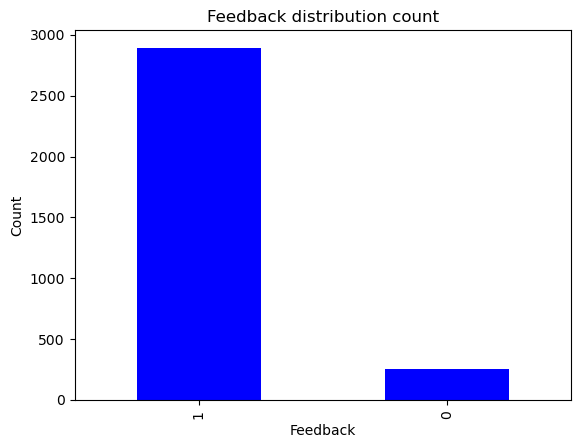

In [55]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [56]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.84
0     8.16
Name: count, dtype: float64


Feedback distribution <br>
* 91.84% reviews are positive <br>
* 8.16% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

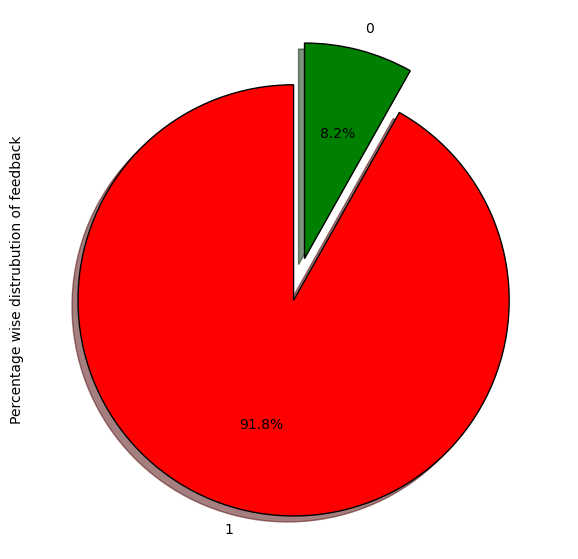

In [57]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [58]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     96
Name: count, dtype: int64

In [59]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [60]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


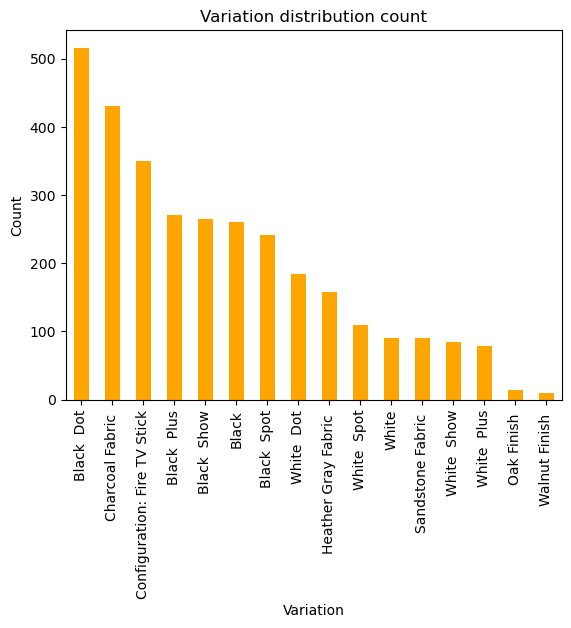

In [61]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [62]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


Mean rating according to variation

In [63]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.142857
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

Let's analyze the above ratings

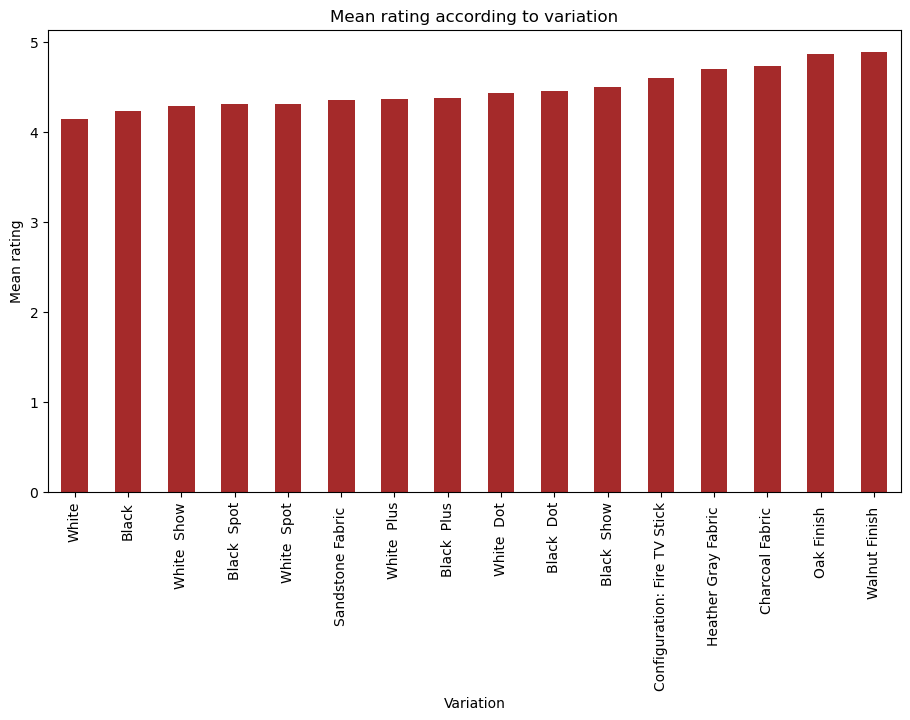

In [64]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [65]:
data['length'].describe()

count    3150.000000
mean      132.672381
std       182.527862
min         0.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

Length analysis for full dataset

C:\Users\Erjon\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review ')]

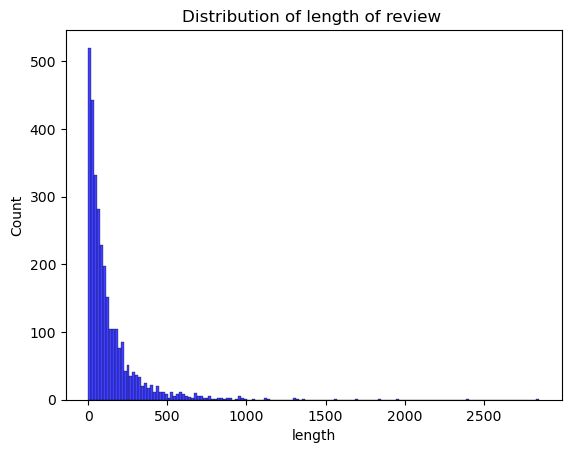

In [66]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

C:\Users\Erjon\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

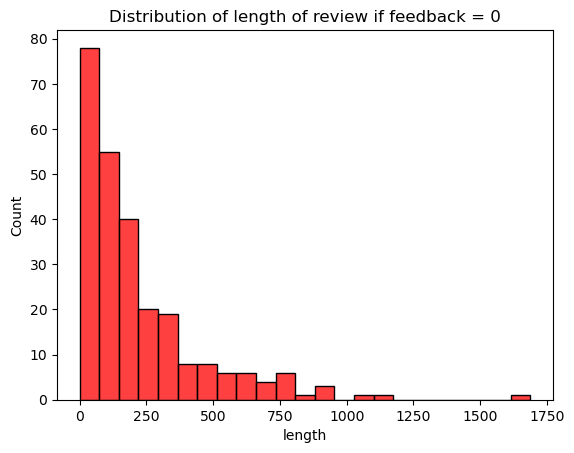

In [67]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

C:\Users\Erjon\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

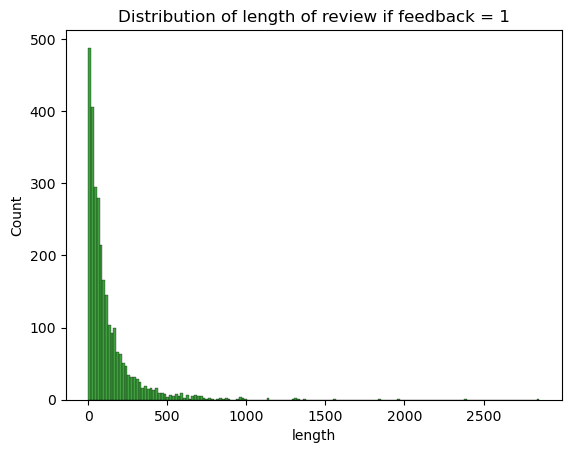

In [68]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

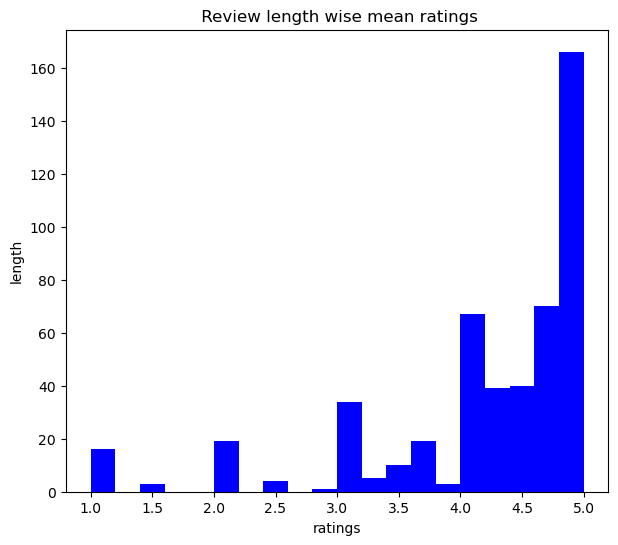

In [69]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [74]:
# Fill NaN values with an empty string
data['verified_reviews'] = data['verified_reviews'].fillna('')

# Now apply CountVectorizer
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

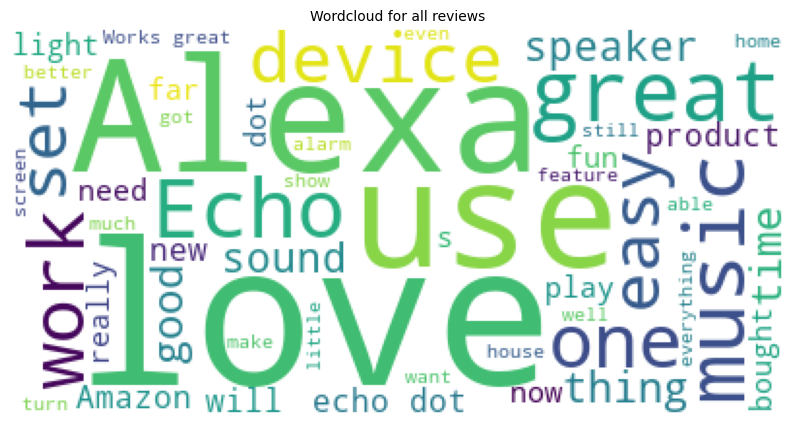

In [75]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [76]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


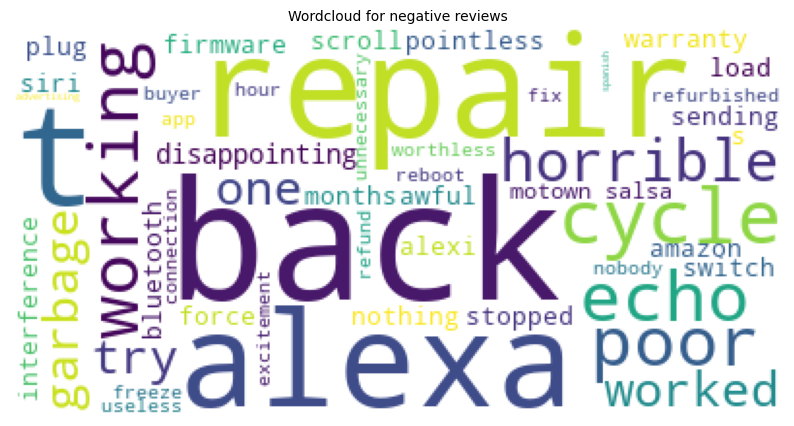

In [77]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

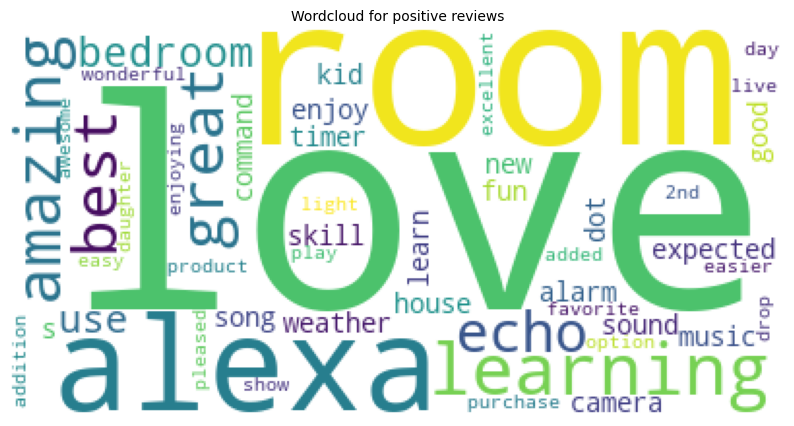

In [78]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [79]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [80]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [81]:
#Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [82]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3150, 2500)
y shape: (3150,)


Splitting data into train and test set with 30% data with testing.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2205, 2500)
y train: (2205,)
X test: (945, 2500)
y test: (945,)


In [84]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


We'll scale X_train and X_test so that all values are between 0 and 1.

In [85]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [86]:
#Saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

#### Random Forest

In [87]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [88]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9407407407407408


In [89]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [90]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

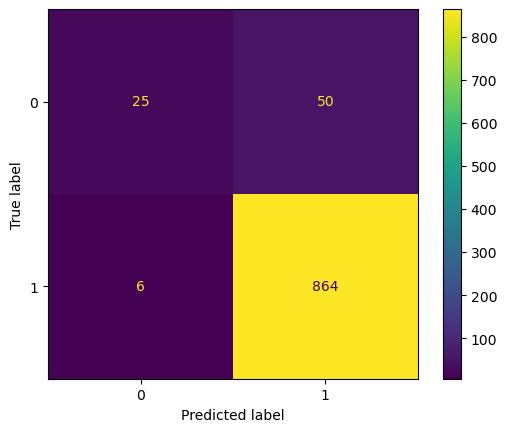

In [91]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [92]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9369703825586179
Standard Variance : 0.013146595887604766


Applying grid search to get the optimal parameters on random forest

In [93]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [94]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [95]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [96]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 97.01837136139189
Cross validation mean accuracy on test set : 92.3241431963314
Accuracy score for test set : 0.9407407407407408


#### XgBoost

In [97]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [98]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9700680272108844
Testing Accuracy : 0.9407407407407408


In [99]:
y_preds = model_xgb.predict(X_test)

In [100]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 25  50]
 [ 10 860]]


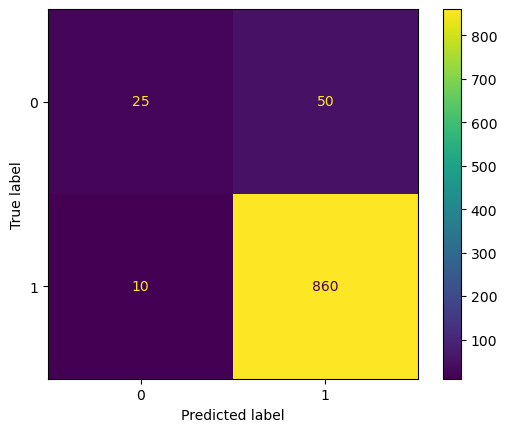

In [101]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [102]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [103]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [104]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9079365079365079


In [105]:
y_preds = model_dt.predict(X_test)

In [106]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 37  38]
 [ 82 788]]


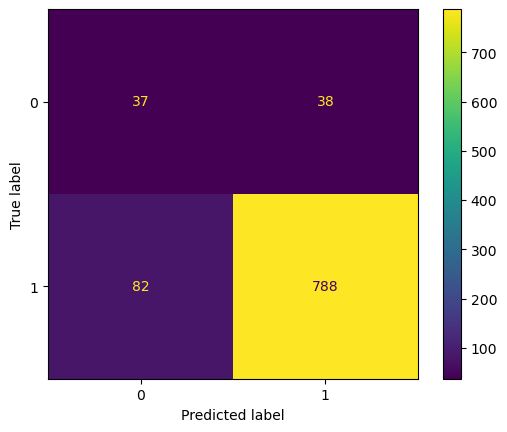

In [107]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [108]:
df = data.copy()

In [109]:
df = df.head(500)
print(df.shape)

(500, 6)


In [110]:
df.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback',
       'length'],
      dtype='object')

### NLTK Basics¶

In [111]:

import nltk
nltk.download('punkt')
import nltk
nltk.download('averaged_perceptron_tagger')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Erjon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Erjon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [112]:
example = df['verified_reviews'][10]
print(example)

"I sent it to my 85 year old Dad, and he talks to it constantly."


In [113]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['``', 'I', 'sent', 'it', 'to', 'my', '85', 'year', 'old', 'Dad']

In [114]:
# https://www.nltk.org/book/ch05.html (tags abrevation meaning)

tagged = nltk.pos_tag(tokens)
tagged[:10]

[('``', '``'),
 ('I', 'PRP'),
 ('sent', 'VBD'),
 ('it', 'PRP'),
 ('to', 'TO'),
 ('my', 'PRP$'),
 ('85', 'CD'),
 ('year', 'NN'),
 ('old', 'JJ'),
 ('Dad', 'NNP')]

In [115]:
import nltk
nltk.download('maxent_ne_chunker')

import nltk
nltk.download('words')



entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Erjon\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Erjon\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  ``/``
  I/PRP
  sent/VBD
  it/PRP
  to/TO
  my/PRP$
  85/CD
  year/NN
  old/JJ
  Dad/NNP
  ,/,
  and/CC
  he/PRP
  talks/VBZ
  to/TO
  it/PRP
  constantly/RB
  ./.
  ''/'')


In [ ]:
import tensorflow as tf
# num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
# print("Num GPUs Available: ", num_gpus_available)
# assert num_gpus_available > 0  # Comment out or remove this line

!pip install transformers
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import pandas as pd
import numpy as np


### Step 2. VADER Seniment Rating

In [117]:
#Printing Frequency Distribution
from nltk.probability import FreqDist
freq_dist = FreqDist(tokens)
print(freq_dist)
freq_dist.most_common(3)

<FreqDist with 17 samples and 19 outcomes>


[('it', 2), ('to', 2), ('``', 1)]

In [118]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Erjon\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [119]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [120]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [121]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [122]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [123]:
# Add an 'Index' column starting from 1
df['Index'] = df.index +1

# If you want this new 'Index' column to be the first column, you can use:
df = df[['Index'] + [col for col in df.columns if col != 'Index']]
df.head()

,Index,rating,date,variation,verified_reviews,feedback,length
0,1,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,2,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,3,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,4,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [124]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['verified_reviews']
    myid = row['Index']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [125]:
res

{1: {'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'compound': 0.6696},
 2: {'neg': 0.0, 'neu': 0.193, 'pos': 0.807, 'compound': 0.636},
 3: {'neg': 0.102, 'neu': 0.784, 'pos': 0.114, 'compound': -0.128},
 4: {'neg': 0.0, 'neu': 0.67, 'pos': 0.33, 'compound': 0.8957},
 5: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 6: {'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'compound': 0.8697},
 7: {'neg': 0.076, 'neu': 0.8, 'pos': 0.124, 'compound': 0.7096},
 8: {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'compound': 0.5563},
 9: {'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249},
 10: {'neg': 0.0, 'neu': 0.749, 'pos': 0.251, 'compound': 0.7482},
 11: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 12: {'neg': 0.0, 'neu': 0.701, 'pos': 0.299, 'compound': 0.9175},
 13: {'neg': 0.042, 'neu': 0.822, 'pos': 0.136, 'compound': 0.7245},
 14: {'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.6988},
 15: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 16: {'neg': 0.261, 'neu

In [126]:
df.dropna(inplace=True)

In [127]:
vaders = pd.DataFrame(res).T

In [128]:
vaders = vaders.reset_index().rename(columns={'index': 'Index'})
vaders = vaders.merge(df, how='left')

In [129]:
vaders

,Index,neg,neu,pos,compound,rating,date,variation,verified_reviews,feedback,length
0,1,0.000,0.308,0.692,0.6696,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,2,0.000,0.193,0.807,0.6360,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,3,0.102,0.784,0.114,-0.1280,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,4,0.000,0.670,0.330,0.8957,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,0.000,1.000,0.000,0.0000,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.539,0.461,0.9370,5,25-Jun-18,Black,"""I love Alexa! It's great helping me, making m...",1,136
496,497,0.000,0.756,0.244,0.6369,5,25-Jun-18,Black,Got this for the bathroom love it we can liste...,1,72
497,498,0.000,0.792,0.208,0.6369,5,25-Jun-18,Black,I have 3-Dots and 2-Original and this new one ...,1,106
498,499,0.303,0.697,0.000,-0.7509,4,25-Jun-18,Black,Was a little hard to get it to pare up with th...,1,89


In [130]:
df.dropna(inplace=True)

In [131]:
vaders.isnull().sum()

Index               0
neg                 0
neu                 0
pos                 0
compound            0
rating              0
date                0
variation           0
verified_reviews    0
feedback            0
length              0
dtype: int64

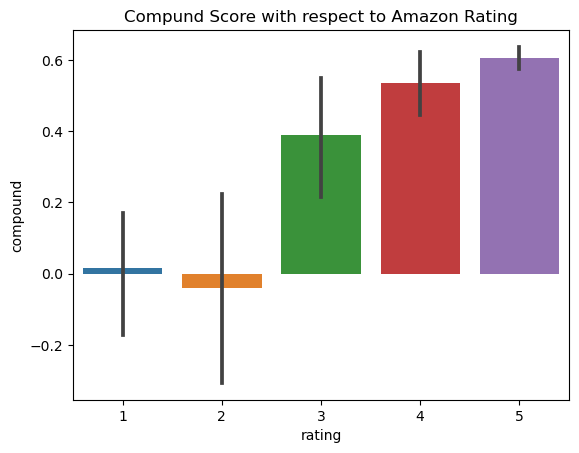

In [132]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score with respect to Amazon Rating')
plt.show()

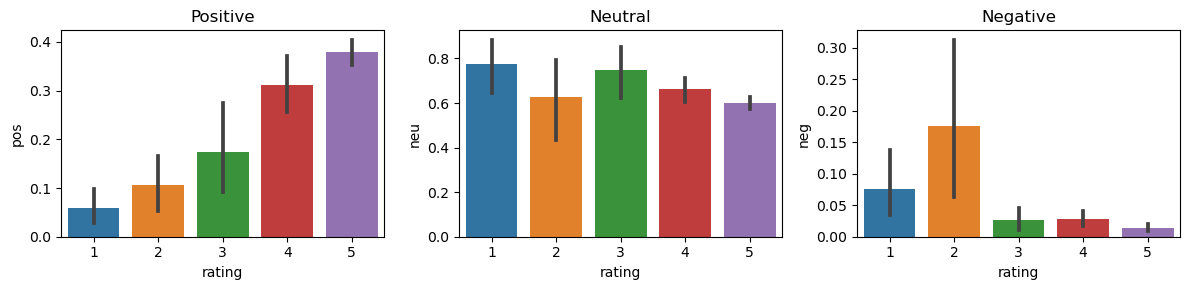

In [133]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [159]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [135]:

import torch
print("PyTorch Version:", torch.__version__)


PyTorch Version: 2.2.1+cpu


In [ ]:
#!pip install tensorflow



In [ ]:
#! pip install numpy

In [136]:
import numpy

In [137]:
import tensorflow

In [138]:
parts_of_speech=nltk.pos_tag(tokens)
parts_of_speech

[('``', '``'),
 ('I', 'PRP'),
 ('sent', 'VBD'),
 ('it', 'PRP'),
 ('to', 'TO'),
 ('my', 'PRP$'),
 ('85', 'CD'),
 ('year', 'NN'),
 ('old', 'JJ'),
 ('Dad', 'NNP'),
 (',', ','),
 ('and', 'CC'),
 ('he', 'PRP'),
 ('talks', 'VBZ'),
 ('to', 'TO'),
 ('it', 'PRP'),
 ('constantly', 'RB'),
 ('.', '.'),
 ("''", "''")]

In [139]:
vaders

,Index,neg,neu,pos,compound,rating,date,variation,verified_reviews,feedback,length
0,1,0.000,0.308,0.692,0.6696,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,2,0.000,0.193,0.807,0.6360,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,3,0.102,0.784,0.114,-0.1280,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,4,0.000,0.670,0.330,0.8957,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,0.000,1.000,0.000,0.0000,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.539,0.461,0.9370,5,25-Jun-18,Black,"""I love Alexa! It's great helping me, making m...",1,136
496,497,0.000,0.756,0.244,0.6369,5,25-Jun-18,Black,Got this for the bathroom love it we can liste...,1,72
497,498,0.000,0.792,0.208,0.6369,5,25-Jun-18,Black,I have 3-Dots and 2-Original and this new one ...,1,106
498,499,0.303,0.697,0.000,-0.7509,4,25-Jun-18,Black,Was a little hard to get it to pare up with th...,1,89


In [140]:
!pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

#Load the pre-trained model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

C:\Users\Erjon\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Erjon\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### Step 3. Roberta Pretrained Model

In [141]:
# VADER results on example
print(example)
sia.polarity_scores(example)

"I sent it to my 85 year old Dad, and he talks to it constantly."


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [142]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.18679169, 'roberta_neu': 0.6769322, 'roberta_pos': 0.13627607}


In [143]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [144]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['verified_reviews']
        myid = row['Index']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [145]:
results_df = pd.DataFrame(res).T


In [146]:
results_df

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
1,0.000,0.308,0.692,0.6696,0.002404,0.014571,0.983025
2,0.000,0.193,0.807,0.6360,0.003420,0.016371,0.980209
3,0.102,0.784,0.114,-0.1280,0.164042,0.415865,0.420093
4,0.000,0.670,0.330,0.8957,0.001857,0.021638,0.976505
5,0.000,1.000,0.000,0.0000,0.119844,0.696196,0.183960
...,...,...,...,...,...,...,...
496,0.000,0.539,0.461,0.9370,0.001922,0.005577,0.992501
497,0.000,0.756,0.244,0.6369,0.002476,0.065461,0.932063
498,0.000,0.792,0.208,0.6369,0.001999,0.037785,0.960216
499,0.303,0.697,0.000,-0.7509,0.060242,0.519777,0.419981


In [147]:
# Reset the index of results_df and make 'Index' a column
results_df = results_df.reset_index().rename(columns={'index': 'Index'})

# Ensure 'Index' is a column in both DataFrames and perform the merge
# Assuming 'Index' is already a column in df
results_df = results_df.merge(df, on='Index', how='left')

In [148]:
results_df

,Index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,rating,date,variation,verified_reviews,feedback,length
0,1,0.000,0.308,0.692,0.6696,0.002404,0.014571,0.983025,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,2,0.000,0.193,0.807,0.6360,0.003420,0.016371,0.980209,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,3,0.102,0.784,0.114,-0.1280,0.164042,0.415865,0.420093,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,4,0.000,0.670,0.330,0.8957,0.001857,0.021638,0.976505,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,0.000,1.000,0.000,0.0000,0.119844,0.696196,0.183960,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.539,0.461,0.9370,0.001922,0.005577,0.992501,5,25-Jun-18,Black,"""I love Alexa! It's great helping me, making m...",1,136
496,497,0.000,0.756,0.244,0.6369,0.002476,0.065461,0.932063,5,25-Jun-18,Black,Got this for the bathroom love it we can liste...,1,72
497,498,0.000,0.792,0.208,0.6369,0.001999,0.037785,0.960216,5,25-Jun-18,Black,I have 3-Dots and 2-Original and this new one ...,1,106
498,499,0.303,0.697,0.000,-0.7509,0.060242,0.519777,0.419981,4,25-Jun-18,Black,Was a little hard to get it to pare up with th...,1,89


In [150]:
results_df.columns


Index(['Index', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'rating', 'date',
       'variation', 'verified_reviews', 'feedback', 'length'],
      dtype='object')

C:\Users\Erjon\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Erjon\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Erjon\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Erjon\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

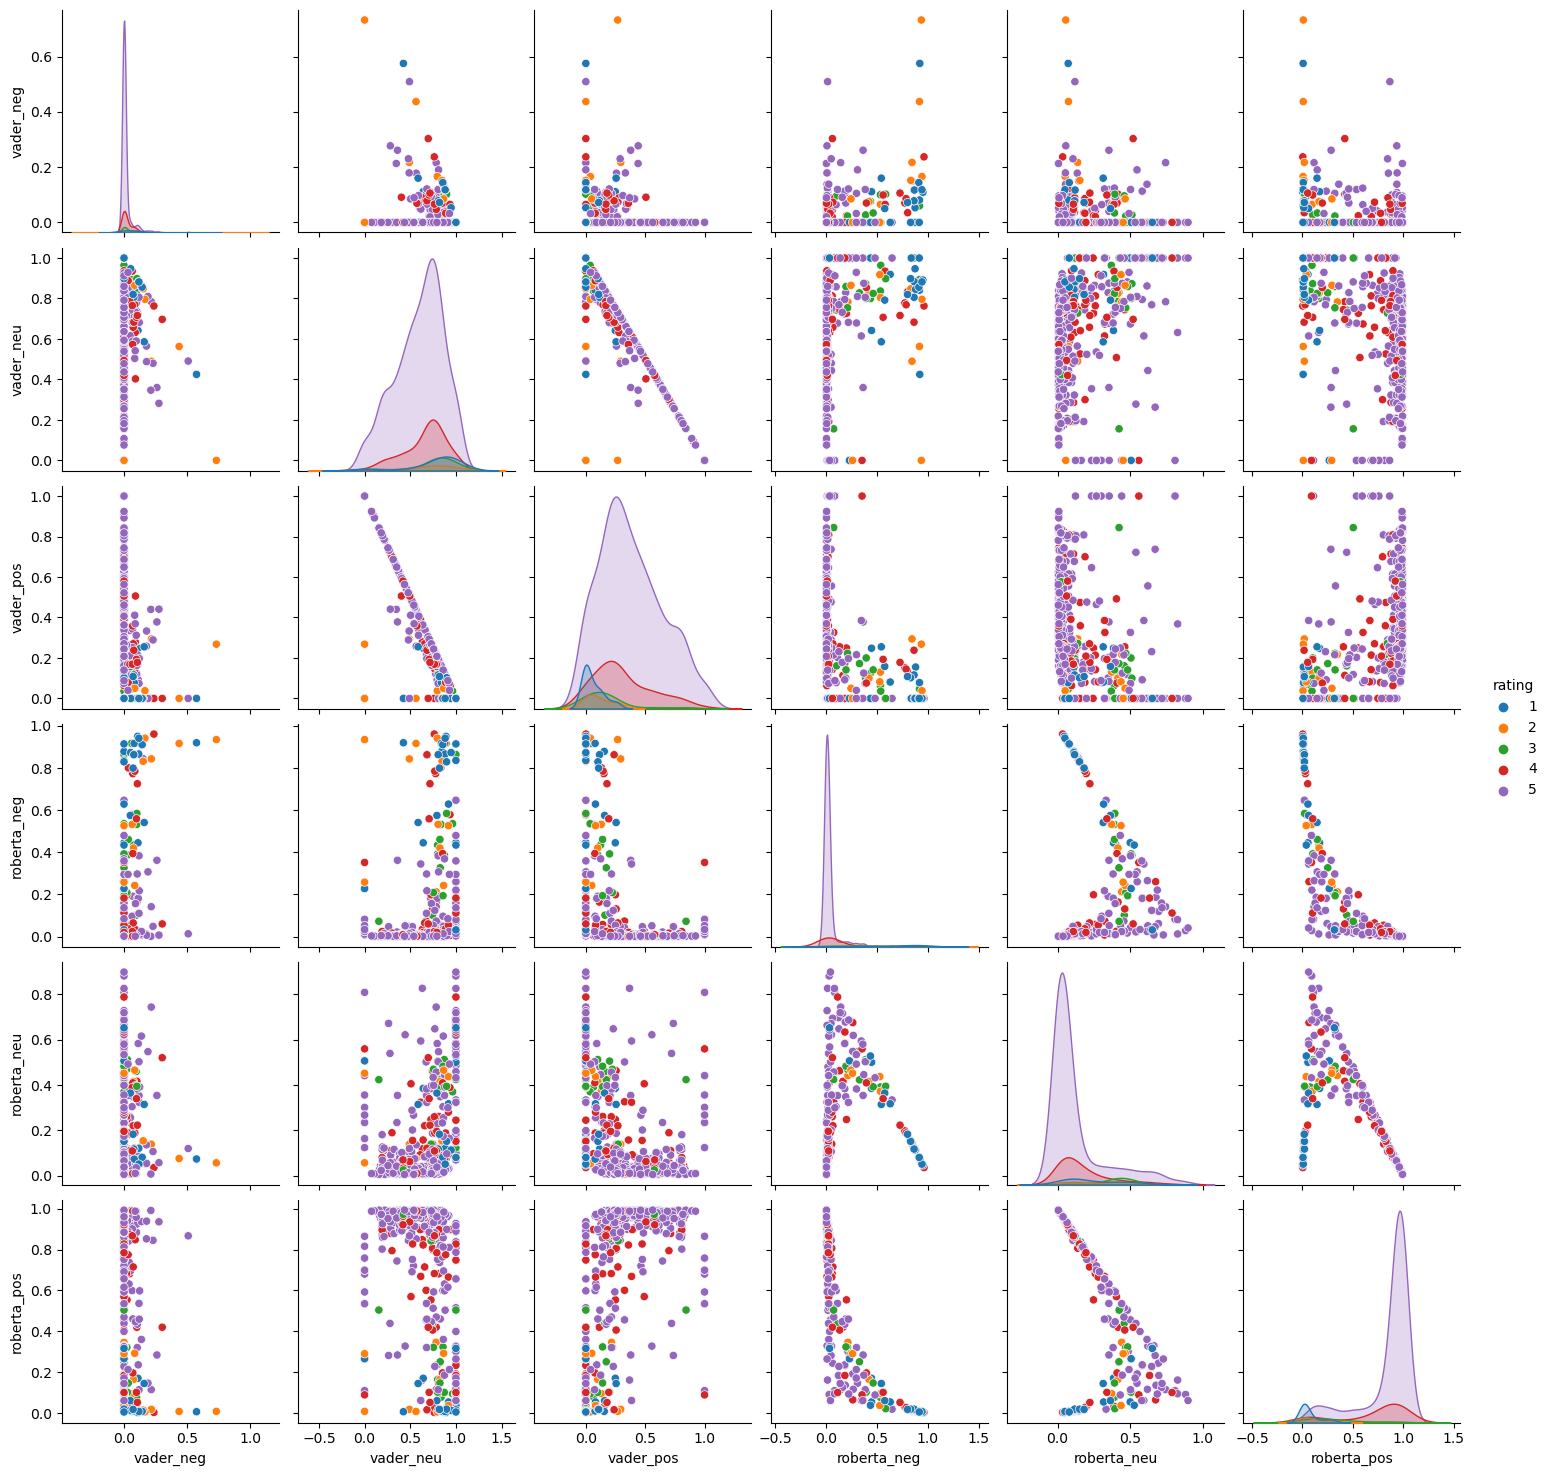

In [151]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating',
            palette='tab10')
plt.show()

In [152]:
results_df.query('rating == 1') \
    .sort_values('roberta_pos', ascending=False)['verified_reviews'].values[0]

"I've already returned it."

In [153]:
results_df.query('rating == 1') \
    .sort_values('vader_pos', ascending=False)['verified_reviews'].values[0]

'Great product but returning for new Alexa Dot.  Refurbished is already giving me problems with connection.'

In [154]:
results_df.query('rating == 5') \
    .sort_values('roberta_neg', ascending=False)['verified_reviews'].values[0]

'As described and received on time.  Do not like automatic enrolment into music.'

In [155]:
results_df.query('rating == 5') \
    .sort_values('vader_neg', ascending=False)['verified_reviews'].values[0]

'Looks and performs as new.  No complaints!'

In [158]:
# !pip install tf-keras

  Using cached tf_keras-2.16.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tf_keras-2.16.0-py3-none-any.whl (1.7 MB)


In [160]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [161]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [162]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [163]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# More to study

# More Analysis of Amazon product Listings (product.csv)

### Check Review count with respect to Pricec (to check if most bought product have high ratings if review count increases)

### Check Rating with respect to product title (most liked porduct)

### Check Price of most bought product

In [164]:
import sys
print(sys.version)

3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
